## Inception Score (IS) and Frechet Inception Distance (FID)

Both the Inception Score (or IS) and the Frechet Inception Distance (or FID) are metrics to assess the quality of images generated by a GAN. 

### Generated data

To calculate the Inception Score and the Frechet Inception Distance, we are going to use some generated samples from the previous exercise. The `samples.pickle` contains 800 samples recorded over 50 epochs (16 samples per epoch). We can visualize them below. The samples are saved as `np.array` and contain images in the [0, 255] range.

In [1]:
import pickle
from typing import List

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# helper function for visualization.

def view_samples(epoch: int, samples: List[np.array]):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[16 * epoch: 16 * (epoch + 1)]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [3]:
with open('../samples.pkl', 'rb') as f:
    samples = pickle.load(f)

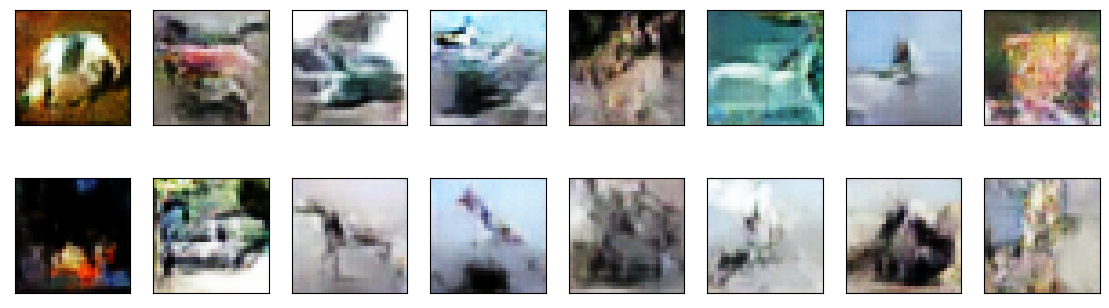

In [60]:
view_samples(27, samples)

### Inception score

The Inception Score was introduced by the [Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498.pdf) paper. This metric relies on the following approach:
* generated images are fed through the [Inception model](https://arxiv.org/pdf/1409.4842.pdf) pretrained on the ImageNet dataset
* the probability distribution for each image should have [low-entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). In other words, the model should output high probabilities for a single class and be confident that the image contains one object. We call this distribution the **conditional label distribution**.
* the probability distribution of all the classes over the whole dataset should have high entropy, meaning that the generative model creates images with high variability. We call this distribution the **marginal distribution**.

The inception score is calculated using the [Kullback–Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL Divergence). 

<img src='../assets/kl_divergence.png' width=50% />


The KL divergence is a measure of how two distributions are similar. Since we want the conditional label distribution to have [low entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) (think of a very low spread gaussian for example) and the marginal distribution to have high entropy (think uniform distribution), we want to **maximize the KL divergence**. 

<img src='../assets/fid_score.png' width=90% />

[This article](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a) explains the inception score in great depth. 

#### Tips:
* look at the [scipy.stats.entropy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function for the kl divergence calculation.
* you can find the pytorch Inception_v3 model [here](https://pytorch.org/hub/pytorch_vision_inception_v3/). Don't forget to reshape the inputs! 

In [5]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
from tqdm import tqdm

In [47]:
def calculate_scores(samples: List[np.array]):
    """
    This function calculates the score for each sample.
    """
    # load model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    inception_model.cuda()
    
    # preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])    
    
    # forward pass
    scores = []
    for image in tqdm(samples):
        image = Image.fromarray(image)
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0).cuda()
        output = inception_model(input_batch)
        probs = torch.nn.functional.softmax(output[0].cpu().detach(), dim=0)
        scores.append(probs.numpy())
    return scores

In [48]:
scores = calculate_scores(samples)

100%|██████████| 800/800 [00:41<00:00, 19.11it/s]


In [49]:
# np.unique(np.std(np.array(scores), axis=1) ).shape
scores[0].max()

0.16482593

In [52]:
np.array(scores).shape
np.mean(scores, axis=0).shape

(1000,)

In [57]:
def get_inception_score(scores: List[np.array]):
    total_scores = []
    py = np.mean(scores, axis=0)

    # calculate the kl divergence
    kl = []
    for pyx in scores:
        ent = entropy(pyx, py)
        kl.append(ent)
    return kl, np.exp(np.mean(kl))

In [58]:
kl, inception_score = get_inception_score(scores)
print(inception_score)
print(kl[0])

3.5226977
1.3450363


### Frechet Inception Distance

The Frechet Inception Distance was first introduced by the [GANs Trained by a Two Time-Scale Update Rule
Converge to a Local Nash Equilibrium](https://arxiv.org/pdf/1706.08500.pdf) paper. 

The Inception Score was a groundbreaking metric for measure GAN performances but it has a major flaw: **it does not take into account the statistics of the "real" dataset the GAN is supposed to mimic and only uses the generated images.**


The FID takes a different approach:
* for each image in the generated dataset **and** the target (real) dataset, get the latent representation by running the Inception model. The latent representation of each image is the output of the penultimate layer, before the final classification layer.
* calculate the mean and the covariance of the real distribution ($m_{r}$ and $C_{r}$)
* calculate the mean and the covariance of the generated distribution ($m_{g}$ and $C_{g}$)
* calculate the Frechet Distance defined below:

$FID = ||m_{r} - m_{g}||^{2}_{2} + Tr(C_{r}) + Tr(C_{g}) - 2 Tr(C_{r}C_{g})^{1/2}$

where $||.||_{2}$ is the L-2 norm and $Tr$ the trace of the covariance matrices. 


In this exercise, we will simply ask you to implement the FID calculation, assuming that you already have calculated the mean and covariance of both distribution.

<br>
<br>
<details>
<summary>
<font size="3" color="black">
<b>Click for tips</b>
</font>
</summary>

* you can calculate the trace of the covariance matrices using `np.trace`
</details>

In [11]:
from scipy import linalg

In [12]:
def get_fid(mu1: np.array, sigma1: np.array, mu2: np.array, sigma2: np.array):
    """
    Calculate the FID. 
    """
    diff = mu1 - mu2
    
    # calculate the square root of the dot product of the covariance matrices
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    # calculate the trace
    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)

In [13]:
samples1 = np.random.randn(100, 2048)
mu1 = np.mean(samples1, axis=0)
sigma1 = np.cov(samples1)

samples2 = np.random.randn(100, 2048)
mu2 = np.mean(samples2, axis=0)
sigma2 = np.cov(samples2)

In [14]:
fid = get_fid(mu1, sigma1, mu2, sigma2)
print(fid)

42.56451679393538
